# Pruebas con datos sintéticos de la red Mask R-CNN para segmentación

### Importar bibliotecas de detectron2, os, random, matplotlib y opencv

In [1]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import get_detection_dataset_dicts
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import ColorMode
import os
import random
import cv2

### Registrar el dataset de pruebas y entrenamiento, con sus archivo .json y el nombre de la carpeta de las imágenes:

In [2]:
register_coco_instances("UCSP Fondecyt Dataset test", {}, "coco_dataset_test.json", "new_images")
register_coco_instances("UCSP Fondecyt Dataset train", {}, "coco_dataset_train.json", "new_images")

### Obtener un archivo de configuración y asignarle las configuraciones de nuestro modelo:

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("UCSP Fondecyt Dataset train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

### Configurar los parámetros para realizar las pruebas y crear un predictor:

In [4]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("UCSP Fondecyt Dataset test", )
predictor = DefaultPredictor(cfg)

### Crear una carpeta para guardar los pesos entrenados y los resultados de las pruebas, además crear un "trainer":

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

[05/27 23:39:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/27 23:39:49 d2.data.datasets.coco]: Loaded 2386 images in COCO format from coco_dataset_train.json
[05/27 23:39:49 d2.data.build]: Removed 0 images with no usable annotations. 2386 images left.
[05/27 23:39:49 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   pieza0   | 797          |   pieza1   | 793          |   pieza2   | 796          |
|            |              |            |              |            |              |
|   total    | 2386         |            |              |            |              |
[05/27 23:39:49 d2.data.common]: Serializing 2386 elements to byte tensors and concatenating them all ...
[05/27 23:39:49 d2.data.common]: Serialized dataset takes 1.86 MiB
[05/27 23:39:49 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640,

### Cargar pesos de la red neuronal si es que ya se ha entrenado:

In [6]:
trainer.resume_or_load(resume=False)

### Visualizar 3 ejemplos aleatorios de la predicción sobre el conjunto de pruebas:

[05/27 23:40:17 d2.data.datasets.coco]: Loaded 614 images in COCO format from coco_dataset_test.json
[05/27 23:40:17 d2.data.build]: Removed 0 images with no usable annotations. 614 images left.
[05/27 23:40:17 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   pieza0   | 203          |   pieza1   | 207          |   pieza2   | 204          |
|            |              |            |              |            |              |
|   total    | 614          |            |              |            |              |


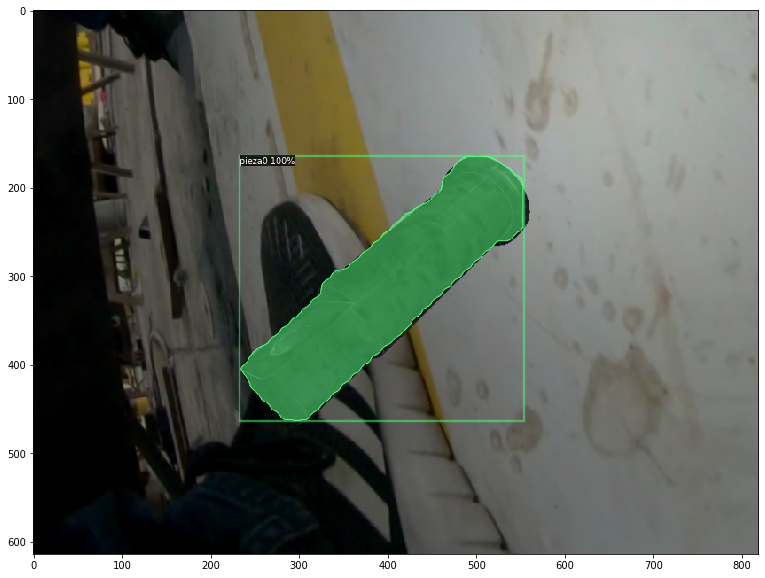

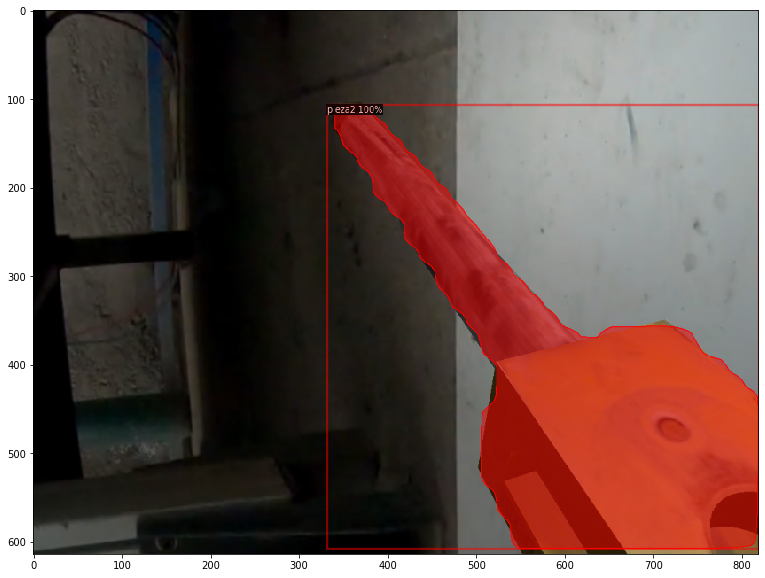

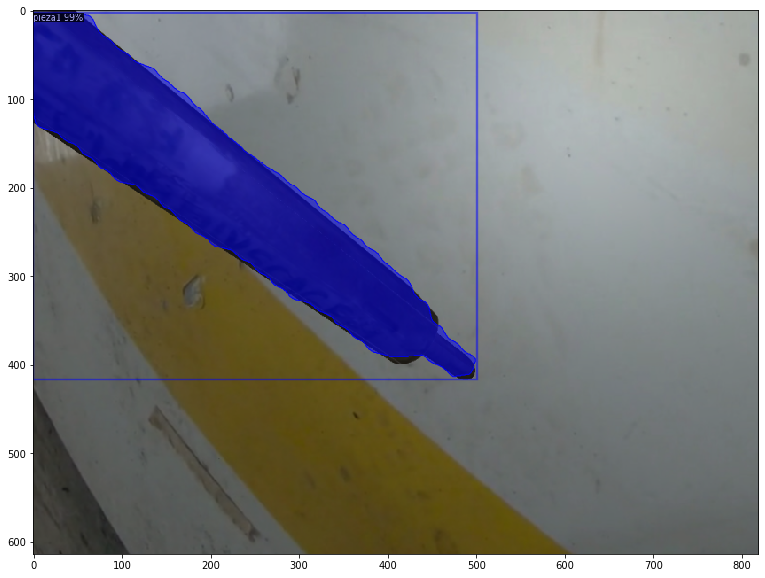

In [7]:
dataset_dicts = get_detection_dataset_dicts(["UCSP Fondecyt Dataset test"])
dataset_metadata = MetadataCatalog.get("UCSP Fondecyt Dataset test")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.8
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,10))
    #plt.figure()
    plt.imshow(v.get_image())

### Evaluar métrica mAP sobre el conjunto de pruebas:

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("UCSP Fondecyt Dataset test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "UCSP Fondecyt Dataset test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/27 23:58:10 d2.data.datasets.coco]: Loaded 614 images in COCO format from coco_dataset_test.json
[05/27 23:58:10 d2.data.common]: Serializing 614 elements to byte tensors and concatenating them all ...
[05/27 23:58:10 d2.data.common]: Serialized dataset takes 0.48 MiB
[05/27 23:58:10 d2.evaluation.evaluator]: Start inference on 614 images
[05/27 23:58:15 d2.evaluation.evaluator]: Inference done 11/614. 0.4328 s / img. ETA=0:04:23
[05/27 23:58:20 d2.evaluation.evaluator]: Inference done 23/614. 0.4319 s / img. ETA=0:04:17
[05/27 23:58:25 d2.evaluation.evaluator]: Inference done 35/614. 0.4323 s / img. ETA=0:04:12
[05/27 23:58:31 d2.evaluation.evaluator]: Inference done 47/614. 0.4327 s / img. ETA=0:04:07
[05/27 23:58:36 d2.evaluation.evaluator]: Inference done 59/614. 0.4341 s / img. ETA=0:04:03
[05/27 23:58:41 d2.evaluation.evaluator]: Inference done 71/614. 0.4368 s / img. ETA=0:03:59
[05/27 23:58:47 d2.evaluation.evaluator]: Inference done 83/614. 0.4378 s / img. ETA=0:03:54
[05/

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.945
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.962
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.962
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.962
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

OrderedDict([('bbox',
              {'AP': 97.97140837593601,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': 90.0,
               'APl': 98.00021126456224,
               'AP-pieza0': 99.45568057659247,
               'AP-pieza1': 97.11550256739389,
               'AP-pieza2': 97.34304198382164}),
             ('segm',
              {'AP': 94.50846652733091,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': 92.52475247524752,
               'APl': 94.50430725443701,
               'AP-pieza0': 99.7980783300005,
               'AP-pieza1': 94.3006087202175,
               'AP-pieza2': 89.4267125317747})])